In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from scipy.signal import convolve2d

In [3]:
from scipy.optimize import fixed_point, root_scalar

In [4]:
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm

In [5]:
L=np.array([[1/4,1/2,1/4], [1/2, -3,1/2], [1/4,1/2,1/4]])

In [6]:
def gaussianFluctH(lx, ly, h0):
    x, y = np.meshgrid(np.arange(lx), np.arange(ly))
    dst = np.sqrt((x-lx/2)*(x-lx/2)+(y-ly/2)*(y-ly/2))

    sig=3
    gauss = h0*np.exp(-( (dst)**2 / ( 2.0 * sig**2 ) ) )
    return(gauss)

In [7]:
def dx(u, ds):
    return((np.roll(u, axis=1,shift=-1)-np.roll(u, axis=1,shift=1))/(2*ds))

In [8]:
def dy(u, ds):
    return((np.roll(u, axis=0,shift=-1)-np.roll(u, axis=0,shift=1))/(2*ds))

In [58]:
def update_X_clock_model(X, v, D, beta, dt, ds, ly):
    rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]   
    
    # derivative along x : np.roll(m, axis=1)
    dxmx=dx(mx,ds)
    dymx=dy(mx,ds)
    dxmy=dx(my,ds)
    dymy=dy(my,ds)
    
    drho = rho \
    #- v*(dt/dx)*(np.roll(my, axis=0,shift=-1)-np.roll(my, axis=0,shift=1))/2\
    - v*dt*dymy \
    #- v*(dt/dx)*(np.roll(mx, axis=1,shift=-1)-np.roll(mx, axis=1,shift=1))/2\
    - v*dt*dxmx \
    + D*(dt/(ds*ds))*convolve2d(rho, L, mode='same', boundary='wrap')
    
    norm_m=np.sqrt(mx*mx+my*my)
    
    dmx = mx\
    - 0.5*v*dt*dx(rho,ds) \
    + D*(dt/(ds*ds))*convolve2d(mx, L, mode='same', boundary='wrap')\
    + dt*(beta/2-1-beta*beta*norm_m*norm_m/(8*rho*rho))*mx
    - dt*(beta*v/(4.*rho))*(my*(-dxmy+dymx) + mx*(dxmx+dymy))
       
    dmy = my \
    - 0.5*v*dt*dy(rho,ds) \
    + D*(dt/(ds*ds))*convolve2d(my, L, mode='same', boundary='wrap') \
    + dt*(beta/2-1-beta*beta*norm_m*norm_m/(8*rho*rho))*my
    + dt*(beta*v/(4.*rho))*(mx*(-dxmy+dymx) - my*(dxmx+dymy))
    
    return(np.concatenate([drho, dmx, dmy]))

In [59]:
lx=400
ly=200
ds=1

tmax=100
dt=0.1
vec_t=np.arange(0,tmax,dt)

v=4
beta=4
D=1

In [60]:
# INITIAL CONDITION : fluctuation in liq phase
rho=5*np.ones((ly,lx))
mx=2*rho*np.sqrt(beta-2)/beta
#my=myl_vec[nD]*np.ones((ly,lx))
my=np.zeros((ly,lx))


h0=100
mx-=3*mx[0,0]*gaussianFluctH(lx, ly, h0)
#my-=3*my[0,0]*gaussianFluctH(lx, ly, h0)

rho+=rho[0,0]*gaussianFluctH(lx, ly, h0)

X=np.concatenate([rho, mx, my])

In [61]:
prof_rho=[]
prof_mx=[]
prof_my=[]

rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]
prof_rho.append(rho.copy())
prof_mx.append(mx.copy())
prof_my.append(my.copy())


for t in vec_t:
    X0=X.copy()
    
    X=update_X_clock_model(X0, v, D, beta, dt, ds, ly)
    
    rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]  
    prof_rho.append(rho)
    prof_mx.append(mx)
    prof_my.append(my)

In [50]:
# LAUNCH TO RESUME SIMU
t_long=1000
vec_t_long=np.arange(0,t_long,dt)

for t in vec_t_long:
    X0=X.copy()
    
    X=update_X_clock_model(X0, v, D, beta, dt, ds, ly)
    
    rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]  
    prof_rho.append(rho)
    prof_mx.append(mx)
    prof_my.append(my)

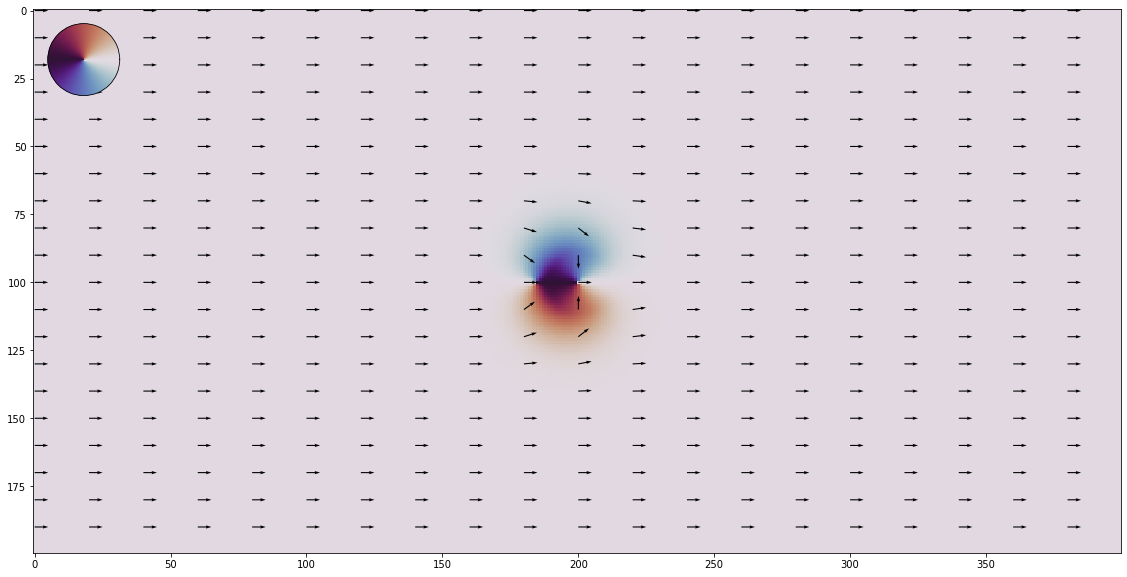

In [74]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)

azimuths = np.arange(-180, 181, 1)
zeniths = np.arange(0, 20, 1)
values = azimuths * np.ones((20, 361))

ax2 = fig.add_axes([0.12, 0.76, 0.1, 0.1], polar=True,)

ax2.pcolormesh(azimuths*np.pi/180.0, zeniths, values, cmap='twilight_shifted')
ax2.set_yticks([])
ax2.set_xticks([])

t=-1
mxp=prof_mx[t].copy()
myp=prof_my[t].copy()
ax.imshow(np.arctan2(myp,mxp), cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi)

stepx=10
stepy=20
x, y = np.meshgrid(np.arange(lx), np.arange(ly))
norm=np.sqrt(mxp[::stepx, ::stepy]**2+myp[::stepx, ::stepy]**2)
ax.quiver(x[::stepx, ::stepy],y[::stepx, ::stepy],mxp[::stepx, ::stepy]/norm,myp[::stepx, ::stepy]/norm, scale=80, width=1e-3)

plt.show()

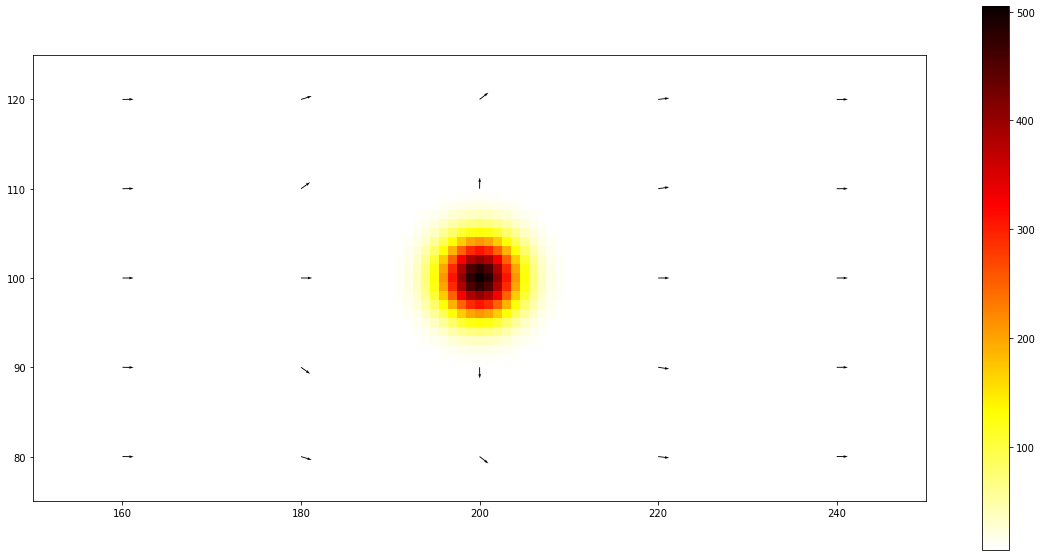

In [76]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)

t=-1
mxp=prof_mx[t].copy()
myp=prof_my[t].copy()
#ax.imshow(np.arctan2(myp,mxp), cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi)
im=ax.imshow(prof_rho[t], cmap='hot_r')
plt.colorbar(im)

stepx=10
stepy=20
x, y = np.meshgrid(np.arange(lx), np.arange(ly))
norm=np.sqrt(mxp[::stepx, ::stepy]**2+myp[::stepx, ::stepy]**2)
ax.quiver(x[::stepx, ::stepy],y[::stepx, ::stepy],mxp[::stepx, ::stepy]/norm,myp[::stepx, ::stepy]/norm, scale=80, width=1e-3)

plt.xlim(150, 250)
plt.ylim(75,125)
plt.show()

# Movies

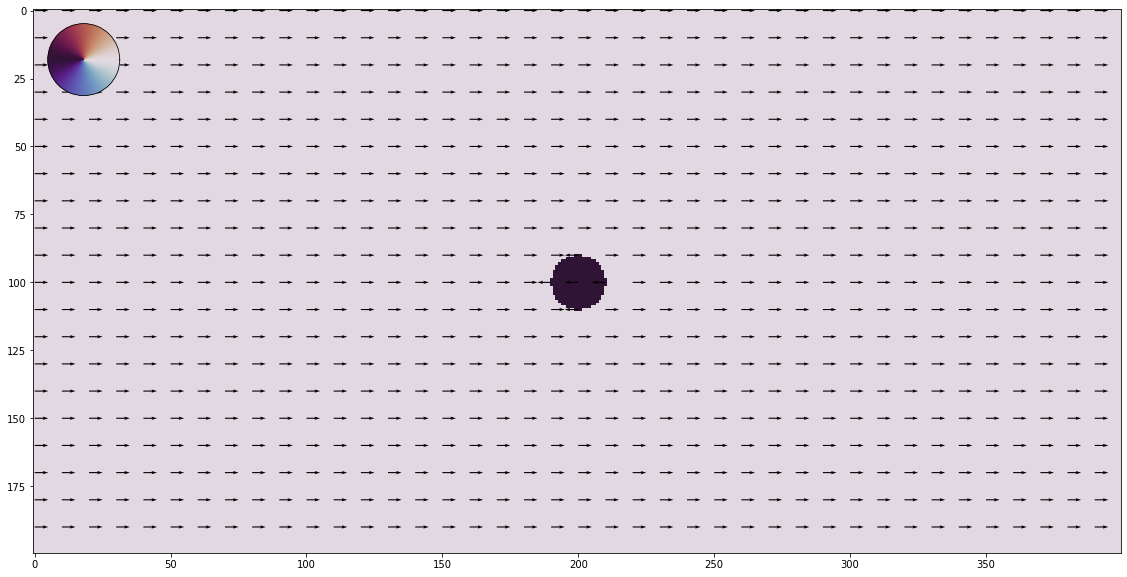

In [140]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
fig.set_size_inches(20,10)

azimuths = np.arange(-180, 181, 1)
zeniths = np.arange(0, 20, 1)
values = azimuths * np.ones((20, 361))

ax2 = fig.add_axes([0.12, 0.76, 0.1, 0.1], polar=True,)

ax2.pcolormesh(azimuths*np.pi/180.0, zeniths, values, cmap='twilight_shifted')
ax2.set_yticks([])
ax2.set_xticks([])

frame=0

mxp=prof_mx[frame].copy()
myp=prof_my[frame].copy()
img=ax.imshow(np.arctan2(myp,mxp), cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi)


norm=np.sqrt(mxp[::stepx, ::stepy]**2+myp[::stepx, ::stepy]**2)
quiv=ax.quiver(x[::stepx, ::stepy],y[::stepx, ::stepy],mxp[::stepx, ::stepy]/norm,myp[::stepx, ::stepy]/norm, scale=80, width=1e-3)

plt.show()

def update(*args):
    global frame
    #print(frame)

    mxp=prof_mx[frame]
    myp=prof_my[frame]
    
    img.set_array(np.arctan2(myp,mxp))
    
    norm=np.sqrt(mxp[::stepx, ::stepy]**2+myp[::stepx, ::stepy]**2)
    quiv.set_UVC(mxp[::stepx, ::stepy]/norm,myp[::stepx, ::stepy]/norm)
    
    frame += 11

    return img,

ani = animation.FuncAnimation(fig, update, 1000)
writer = animation.FFMpegWriter(fps=20)
ani.save('destab_alpha%.1f_h%.1f_v%.1f_beta%.1f_D%.1f.avi'%(alpha, h0, v, beta, D), writer=writer) 